# 第三次作业
### 姓名：张家琪
### 班级：2020211601
### 学号：2020211178

# 作业目的
理解图像灰度变换的基本原理，掌握灰度变换的实现方法

## (1) 理解图像灰度变换的基本原理，掌握灰度变换的实现方法

Text(0.5, 1.0, 'gray_l=32')

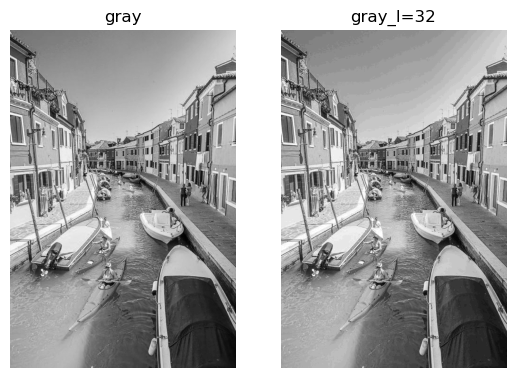

In [1]:
from skimage import io
import matplotlib.pylab as plt

# 读取灰度图像
img_gray=io.imread("gray.bmp")
plt.subplot(121)
plt.imshow(img_gray,plt.cm.gray)
plt.axis("off")
plt.title("gray")

# 量化深度为5bits，分为32个等级;原图为8bits量化，有256个等级
l=32
ratio=int(256/l)
for i in range(img_gray.shape[0]):
    for j in range(img_gray.shape[1]):
        img_gray[i,j]=int(img_gray[i,j]/ratio)*ratio

plt.subplot(122)
plt.imshow(img_gray,plt.cm.gray)
plt.axis("off")
plt.title("gray_l=32")

经比较，灰度等级量化为32的图片图像颜色变化更不自然，图像质量有所下降。

### 描述均匀量化的算法原理

均匀量化是指把输入信号的取值域等间隔分割的量化。如果要把一张8bits量化的灰度图像转换为5bits均匀量化（即32个颜色等级）的图像，那么在8bits量化的图像中颜色为[1,8]的将被分配到0或者8两个数值；同理，颜色为[9,16]的将被分配到8或者16两个数值上，以此类推。

Text(0.5, 1.0, 'gray_l=8')

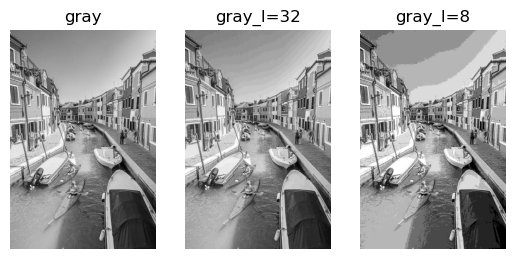

In [2]:
# 测试不同均匀量化等级
# 读取灰度图像
img_gray=io.imread("gray.bmp")
plt.subplot(131)
plt.imshow(img_gray,plt.cm.gray)
plt.axis("off")
plt.title("gray")

# 量化深度为5bits，分为32个等级
l=32
ratio=int(256/l)
for i in range(img_gray.shape[0]):
    for j in range(img_gray.shape[1]):
        img_gray[i,j]=int(img_gray[i,j]/ratio)*ratio

plt.subplot(132)
plt.imshow(img_gray,plt.cm.gray)
plt.axis("off")
plt.title("gray_l=32")

# 量化深度为3bits，分为8个等级
l=8
ratio=int(256/l)
for i in range(img_gray.shape[0]):
    for j in range(img_gray.shape[1]):
        img_gray[i,j]=int(img_gray[i,j]/ratio)*ratio

plt.subplot(133)
plt.imshow(img_gray,plt.cm.gray)
plt.axis("off")
plt.title("gray_l=8")

## (2) 选取一张彩色图像，采用K-means方法将图像的颜色量化为128种颜色，比较量化前后图像质量的差异

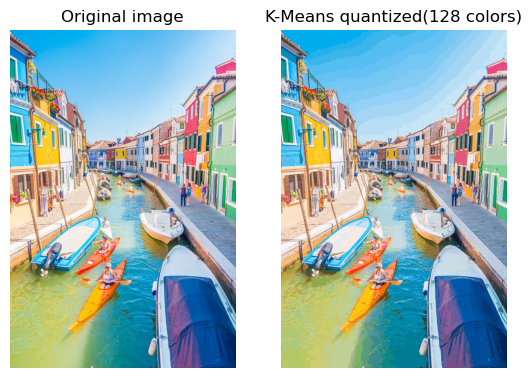

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle

n_colors=128 # 量化深度为7bits，共128个等级

# 原图，量化深度为8bits
img_k=io.imread("original.jpg")
plt.subplot(121)
plt.axis("off")
plt.title("Original image")
plt.imshow(img_k)

# 数据转换到[0,1]的区间，将数据降维为2维数组
img_k=np.array(img_k, dtype=np.float64)/255
w,h,d=original_shape=tuple(img_k.shape)
assert d==3
img_arr=np.reshape(img_k,(w*h,d))

# 对1000个数据样本进行K-Means聚类，得出n_colors（128）个聚类中心
img_arr_sample=shuffle(img_arr,random_state=0,n_samples=1_000)
kmeans=KMeans(n_clusters=n_colors,random_state=0).fit(img_arr_sample)

# 对数据中的所有点预测其属于哪个聚类
labels=kmeans.predict(img_arr)

# 重组图像
def recreate_image(codebook,labels,w,h):
    return codebook[labels].reshape(w,h,-1)

plt.subplot(122)
plt.axis("off")
plt.title(f"K-Means quantized(128 colors)")
plt.imshow(recreate_image(kmeans.cluster_centers_,labels,w,h))

经比较，通过K-Means量化为128种颜色的图片颜色变化更不自然，图像质量有所下降。

## (3) 查阅资料，给出K-means算法原理，给出实现代码及对比结果

### K-means算法原理

K-means是最常用的基于欧式距离的聚类算法，其认为两个目标的距离越近，相似度越大。其算法步骤为：
\
(1) 选择$k$个初始聚类中心$\{a_1,a_2,…,a_k\}$；
\
(2) 针对数据集中$n$个样本$\{x_1,x_2,…,x_n\}$计算它到$k$个聚类中心的距离并将其分到距离最小的聚类中心所对应的类中；
\
(3) 针对$\{a_1,a_2,…,a_k\}$中的每个聚类中心，重新计算$a_i$为聚类中所有点的坐标平均值$a_i=\frac{1}{\mid c_i \mid} \sum_{x\in c_i}x$；
\
重复上面2、3两步操作，直到达到某个中止条件（迭代次数、最小误差变化等）。

### K-means代码

In [4]:
class K_Means(object):
    def __init__(self, k=2, tolerance=0.0001, max_iter=300):
        self.k_ = k # 初始2个聚类中心
        self.tolerance_ = tolerance # 误差大小
        self.max_iter_ = max_iter

    def fit(self, data):
        self.centers_ = {}
        for i in range(self.k_):
            self.centers_[i] = data[i]

        for i in range(self.max_iter_):
            self.clf_ = {}
            for i in range(self.k_):
                self.clf_[i] = []

            for feature in data:
                distances = []
                for center in self.centers_:
                    distances.append(np.linalg.norm(feature - self.centers_[center])) # 计算距离
                classification = distances.index(min(distances))
                self.clf_[classification].append(feature)

            prev_centers = dict(self.centers_)
            for c in self.clf_:
                self.centers_[c] = np.average(self.clf_[c], axis=0)

            optimized = True
            for center in self.centers_:
                org_centers = prev_centers[center]
                cur_centers = self.centers_[center]
                if np.sum((cur_centers - org_centers) / org_centers * 100.0) > self.tolerance_:
                    optimized = False # 如果误差大于tolerance，继续迭代
            if optimized:
                break

    def predict(self, p_data):
        distances = [np.linalg.norm(p_data - self.centers_[center]) for center in self.centers_]
        index = distances.index(min(distances))
        return index

{0: array([1.16666667, 1.46666667]), 1: array([8.        , 9.16666667])}


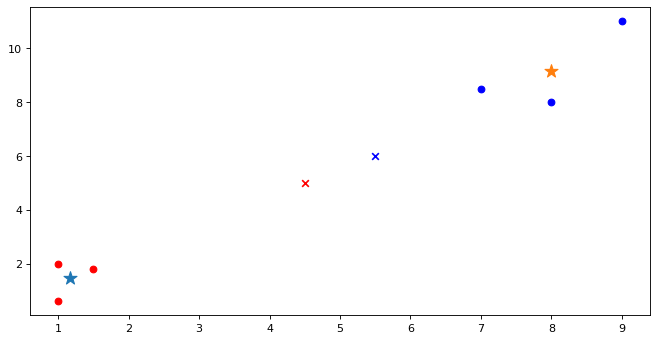

In [5]:
from matplotlib.pyplot import figure
figure(figsize=(10,5),dpi=80)

# 初始数据样本
N = np.array([[1, 2], [1.5, 1.8], [7, 8.5], [8, 8], [1, 0.6], [9, 11]])
k_means = K_Means(k=2)
k_means.fit(N)
# 得出k个聚类中心
print(k_means.centers_)

# 画出聚类中心
for center in k_means.centers_:
    plt.scatter(k_means.centers_[center][0], k_means.centers_[center][1], marker='*', s=150)

# 画出初始样本
for cat in k_means.clf_:
    for point in k_means.clf_[cat]:
        plt.scatter(point[0], point[1], c=('r' if cat == 0 else 'b'))

# 预测点[4.5,5]属于哪一个聚类
predict = [4.5,5]
cat = k_means.predict(predict)
plt.scatter(predict[0], predict[1], c=('r' if cat == 0 else 'b'), marker='x')

# 预测点[5.5,6]属于哪一个聚类
predict_2 = [5.5,6]
cat = k_means.predict(predict_2)
plt.scatter(predict_2[0], predict_2[1], c=('r' if cat == 0 else 'b'), marker='x')

plt.show()